# Single Regression WINGOHOCKING RAIN BARREL ONLY

# Show the collections that have been generated

In [11]:
from pymongo import MongoClient
from process_collection import *
#  IMPORTANT:  Set these for each run:
#################################################
# mongoServer = None   # use the local mongodb server installed on your computer
#mongoServer = 'mongodb://server.mcgarity.info:27017/'  # Art's personal server
#mongoServer = 'mongodb://ubuntu:27017/'  # ubuntu Linux virtual machine on Art's Mac
mongoServer = 'mongodb://aws-2.greenphilly.net:27017/'  # aws-2 server for GreenPhilly
database = "jcohen4"
username = "jcohen4"
password = "wingohocking"
authenticationDatabase = "jcohen4"

client = MongoClient(mongoServer)
################################################

db = client[database]
db.authenticate(username, password, source=authenticationDatabase)  # pass credentials to database
collectionNames = sorted(db.collection_names())
collectionNames

[u'2008',
 u'2008trial1',
 u'2008trial3',
 u'2008trial4',
 u'2008trial6',
 u'first_wingo_test',
 u'fourth_wingo_test',
 u'impervFixed',
 u'impervNotFixed',
 u'july',
 u'july10',
 u'july12',
 u'july13',
 u'july14',
 u'july15',
 u'july16',
 u'july17',
 u'july2',
 u'july21',
 u'july22',
 u'july23',
 u'july24',
 u'july3',
 u'july4',
 u'july5',
 u'july6',
 u'july7',
 u'july8',
 u'july9',
 u'largeTrialLinier',
 u'multivariate_250_2010',
 u'multivariate_random_250_2010',
 u'multivariate_random_250_2011',
 u'multivariate_random_250_2012',
 u'multivariate_random_250_2013',
 u'randomTrial1',
 u'randomTrial2',
 u'randomTrial4',
 u'randomTrial5',
 u'random_multivariate',
 u'random_multivariate2',
 u'random_multivariate2009',
 u'random_multivariate2009year',
 u'random_multivariate2010',
 u'random_multivariate2012year',
 u'random_multivariate250',
 u'random_multivariate250_2009',
 u'random_multivariate3',
 u'random_multivariate5',
 u'random_multivariate6',
 u'random_multivariate7',
 u'random_multiva

In [12]:
from get_cso import calculate_cso
acft_to_mgal = 0.325851  # 1 acre-ft = 0.325851 MGal
collectionName = 'y17m01d11_AEM_45_Subcat_RainBarrel_Only_1'
runs = db[collectionName]
cursor = runs.find()
noLidRun = cursor[0]
noLidDocId = noLidRun['_id']
noLidVolume = noLidRun['volume']  # 10^6 Gal / yr
noLidPeak = noLidRun['peak']   # cfs
noLidRunoff = noLidRun['runoff']  # acre-ft/yr
outflowSeries = noLidRun['outflow_series']
ratio = 0.05
csoResults = calculate_cso(outflowSeries,ratio)
noLidCsoVolumeMGal = csoResults['cso_volume']/1e6
print noLidDocId
print "noLidPeak = %0.2f cfs, noLidVolume = %0.2f MGal" % (noLidPeak,noLidVolume)
print "noLid Runoff = %0.2f acre-ft = %0.2f MGal" % (noLidRunoff,noLidRunoff*acft_to_mgal)
print "noLid csoVolumeMGal = %0.2f MGal" % noLidCsoVolumeMGal
# NOTE: Volume is total flow volume at sewer outlet while Runoff is total runoff volume
#       so they will likely be slightly different
noLidRunParamsList = noLidRun['runParamList']
#print noLidRunParamsList

5876c6c6c101573779a4627b
noLidPeak = 1948.45 cfs, noLidVolume = 1948.90 MGal
noLid Runoff = 5987.73 acre-ft = 1951.11 MGal
noLid csoVolumeMGal = 687.45 MGal


In [13]:
# Compute Annual CSO Flows from results stored on Mongo
from get_cso import * 
from process_collection import * 
collectionName = 'y17m01d11_AEM_45_Subcat_RainBarrel_Only_1'
ratio = 0.05
numSubcatch = 45
numLID = 1
numVariables = numSubcatch*numLID
results = volume_reduction_and_runoff_volume_vs_lid_number(collectionName, numVariables, db)
allDocIds = get_all_doc_ids(collectionName,db)
volReduction = results["volReductionList"]
numberOfRuns = len(volReduction)
volReductionMgal = [x / 1e6 for x in volReduction]
numberOfRuns = len(volReductionMgal)
#print volReduction
# ALERT:  in cso_reduction, collectionName and numSubCatch is never used !!!
csoResults = cso_reduction(collectionName, ratio, numSubcatch, results) 
csoReduction = csoResults["csoReduction"]
csoReductionMgal = [x / 1e6 for x in csoReduction]
#print csoReductionMgal
cso = csoResults["cso"]
#print cso
totVol = csoResults["totalVol"]
print "Number of Runs stored in Database = %d" % numberOfRuns
#print results['numLists'][0]

Number of Runs stored in Database = 714


In [44]:
# Compute total greened acres for each run and greened acres by LID for each run
%matplotlib inline
import matplotlib.pyplot as plt
gaPerLid = [0.1]
lidNumbers = results['numLists']
greenedAcres = []
lidGreenedAcres = {}
greenedAcresThreshold = 2000.0
docIdsGreenedAcresAboveThreshold = []
for lid in range(0,numLID):
    lidGreenedAcres[lid] = []
lidTransposed = zip(*lidNumbers)
for run in range(0,numberOfRuns):
    variable = 0
    lidList = lidTransposed[run]
    gaTotalThisRun = 0.0
    for lid in range(0,numLID):
        gaTotalThisLID = 0.0
        for subcat in range(0,numSubcatch):
            numberLID = lidList[variable]
            thisGreenedAcres = gaPerLid[lid]*numberLID
            gaTotalThisRun += thisGreenedAcres
            gaTotalThisLID += thisGreenedAcres
            variable += 1
        lidGreenedAcres[lid].append(gaTotalThisLID)
    greenedAcres.append(gaTotalThisRun)
    if gaTotalThisRun >= greenedAcresThreshold:
        docIdsGreenedAcresAboveThreshold.append(allDocIds[run])
#print greenedAcres
#print lidGreenedAcres
#print csoReduction
#print [greenedAcres]
print len(csoReductionMgal)
print len(docIdsGreenedAcresAboveThreshold)
#print allDocIds

714
176


CSO REDUCTIONS NEAR 380 MGal/yr:
CSO reduction = 380.41, GreenedAcres = 2326.40, DocID = 5878605cde3fa1252c022841, run index = 609
CSO reduction = 380.18, GreenedAcres = 1133.70, DocID = 587884d4de3fa1252c022889, run index = 681
CSO REDUCTIONS NEAR 440 MGal/yr:
CSO reduction = 440.31, GreenedAcres = 1836.90, DocID = 58788befde3fa1252c022897, run index = 695
CSO reduction = 440.45, GreenedAcres = 1793.40, DocID = 58785ac1de3fa1252c022836, run index = 598
CSO reduction = 440.20, GreenedAcres = 1833.30, DocID = 58787397de3fa1252c022867, run index = 647
LOWER GA: total CSO = 246.99 MGal and CSO REDUCTION = 440.46 MGal
UPPER GA: total CSO = 307.02 MGal and CSO REDUCTION = 380.43 MGal
Lower GA CSO Total for Interval = 6.60 MGal
Upper GA CSO Total for Interval = 9.26 MGal


(0, 500)

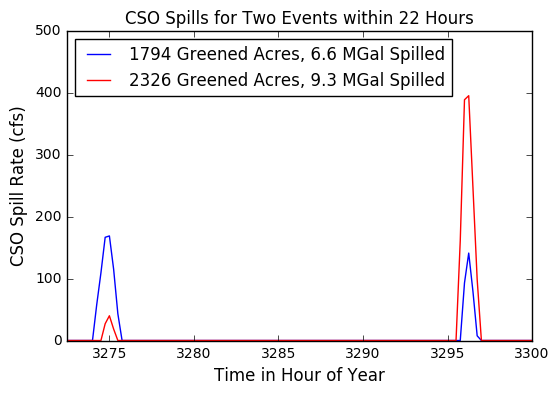

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
from bson.objectid import ObjectId

maxTreatmentLevel = 3122*ratio
docIdThisRun = docIdsGreenedAcresAboveThreshold[174]
for run in range(0,numberOfRuns):
    if docIdThisRun == allDocIds[run]:
        thisIndex = run
        break
#print thisIndex
#print docIdThisRun

# Dictionary to hold docIds for all runs having cso reductions near 380 MGal
csoReductionNear380DocId = {}
for run in range(0,numberOfRuns):
    if csoReductionMgal[run] <= 380.5 and csoReductionMgal[run] >= 379.5:
        csoReductionNear380DocId[run] = allDocIds[run]

print "CSO REDUCTIONS NEAR 380 MGal/yr:"
for run in csoReductionNear380DocId:
    print "CSO reduction = %0.2f, GreenedAcres = %0.2f, DocID = %s, run index = %d" % \
           (csoReductionMgal[run],greenedAcres[run],csoReductionNear380DocId[run], run)
# Found from print statement just above:
docIdLowerGA = ObjectId("58785ac1de3fa1252c022836")

# Dictionary to hold docIds for all runs having cso reductions near 440 MGal
csoReductionNear440DocId = {}
for run in range(0,numberOfRuns):
    if csoReductionMgal[run] <= 440.5 and csoReductionMgal[run] >= 439.5:
        csoReductionNear440DocId[run] = allDocIds[run]

print "CSO REDUCTIONS NEAR 440 MGal/yr:"
for run in csoReductionNear440DocId:
    print "CSO reduction = %0.2f, GreenedAcres = %0.2f, DocID = %s, run index = %d" % \
           (csoReductionMgal[run],greenedAcres[run],csoReductionNear440DocId[run], run)
# Found from print statement just above:



docIdUpperGA = ObjectId("5878605cde3fa1252c022841")

runIndexLowerGA = allDocIds.index(docIdLowerGA) 
runIndexUpperGA = allDocIds.index(docIdUpperGA)      
#print runIndexLowerGA
#print runIndexUpperGA

lowerOutflowSeries = results["outflow_series"][runIndexLowerGA]
upperOutflowSeries = results["outflow_series"][runIndexUpperGA]
numberInTimeSeries = len(upperOutflowSeries)
time_index_15min = range(numberInTimeSeries)
timeHourOfYear = [x/4.0 for x in time_index_15min]

maxTreatmentFlow = []
lowerCsoFlow = []
upperCsoFlow = []
for i in range(numberInTimeSeries):
    maxTreatmentFlow.append(maxTreatmentLevel)
    
    lowerFlowDiff = lowerOutflowSeries[i]-maxTreatmentLevel
    if lowerFlowDiff > 0.0:
        lowerCsoFlow.append(lowerFlowDiff)
    else:
        lowerCsoFlow.append(0.0)

    upperFlowDiff = upperOutflowSeries[i]-maxTreatmentLevel
    if upperFlowDiff > 0.0:
        upperCsoFlow.append(upperFlowDiff)
    else:
        upperCsoFlow.append(0.0)

totLowerCso = sum(lowerCsoFlow)*15.0*60.0*7.48/1e6
totUpperCso = sum(upperCsoFlow)*15.0*60.0*7.48/1e6

totLowerCsoReduction = noLidCsoVolumeMGal - totLowerCso
totUpperCsoReduction = noLidCsoVolumeMGal - totUpperCso
print "LOWER GA: total CSO = %0.2f MGal and CSO REDUCTION = %0.2f MGal" % (totLowerCso,totLowerCsoReduction)
print "UPPER GA: total CSO = %0.2f MGal and CSO REDUCTION = %0.2f MGal" % (totUpperCso,totUpperCsoReduction)

earlierTimeIndex = 13090
laterTimeIndex = 13200

lowerCSOTotalForInterval = 0.0
upperCSOTotalForInterval = 0.0
for tIndex in range(earlierTimeIndex,laterTimeIndex):
    lowerCSOTotalForInterval += lowerCsoFlow[tIndex]
    upperCSOTotalForInterval += upperCsoFlow[tIndex]
lowerCSOTotalForIntervalMGal = lowerCSOTotalForInterval*15.0*60.0*7.48/1e6
upperCSOTotalForIntervalMGal = upperCSOTotalForInterval*15.0*60.0*7.48/1e6

print "Lower GA CSO Total for Interval = %0.2f MGal" % lowerCSOTotalForIntervalMGal
print "Upper GA CSO Total for Interval = %0.2f MGal" % upperCSOTotalForIntervalMGal

(fig, ax1) = plt.subplots()
plt.title("CSO Spills for Two Events within 22 Hours")
ax1.plot(timeHourOfYear,lowerCsoFlow, color = 'b', label = '1794 Greened Acres, 6.6 MGal Spilled')
ax1.plot(timeHourOfYear,upperCsoFlow, color = 'r', label = '2326 Greened Acres, 9.3 MGal Spilled')
ax1.set_xlabel("Time in Hour of Year",fontsize=12)
ax1.set_ylabel("CSO Spill Rate (cfs)",fontsize=12)
#earlierTimeIndex = 0
#laterTimeIndex = numberInTimeSeries
plt.legend(loc='upper left')
plt.xlim([earlierTimeIndex/4.0,laterTimeIndex/4.0])
plt.ylim([0,500])


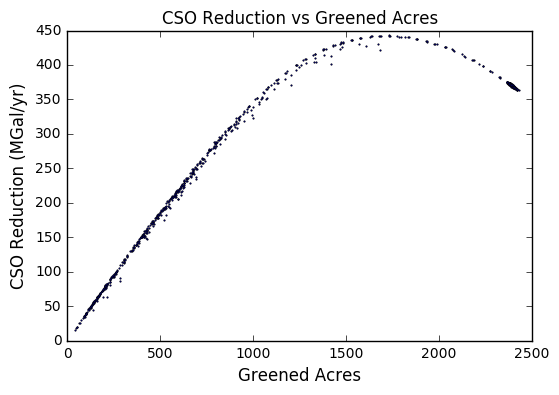

In [16]:
(fig, ax1) = plt.subplots()
plt.title("CSO Reduction vs Greened Acres")
ax1.plot(greenedAcres,csoReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal/yr)",fontsize=12)

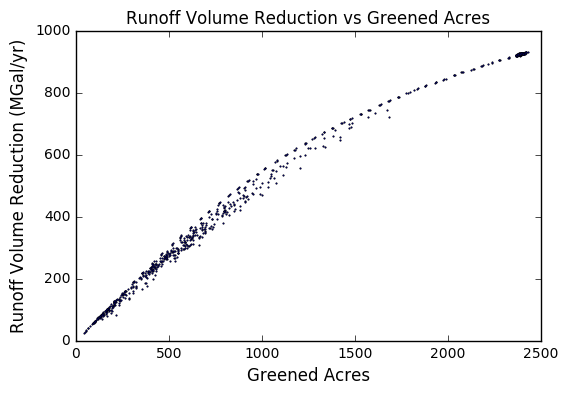

In [17]:
(fig, ax1) = plt.subplots()
plt.title("Runoff Volume Reduction vs Greened Acres")
ax1.plot(greenedAcres,volReductionMgal,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Greened Acres",fontsize=12)
ax1.set_ylabel("Runoff Volume Reduction (MGal/yr)",fontsize=12)

Total number of SWMM runs = 714


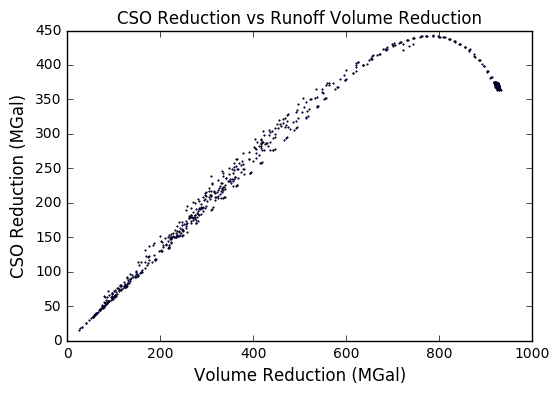

In [18]:
# SCATTER PLOT OF CSO ANNUAL VOLUME REDUCTION VS SEWER OUTFLOW ANNUAL VOLUME REDUCTION
%matplotlib inline
import matplotlib.pyplot as plt
print "Total number of SWMM runs = %d" % len(volReductionMgal)
#xRange = [50,70]
#yRange = [25,45]
(fig, ax1) = plt.subplots()
ax1.plot(volReductionMgal,csoReductionMgal,'ko',color = 'b',markersize = 1)
plt.title("CSO Reduction vs Runoff Volume Reduction")
ax1.set_xlabel("Volume Reduction (MGal)",fontsize=12)
ax1.set_ylabel("CSO Reduction (MGal)",fontsize=12)
#plt.xlim(xRange)
#plt.ylim(yRange)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.402e+05
Date:                Sun, 15 Jan 2017   Prob (F-statistic):               0.00
Time:                        14:33:18   Log-Likelihood:                -7398.9
No. Observations:                 440   AIC:                         1.480e+04
Df Residuals:                     438   BIC:                         1.481e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       7.898e+06   4.94e+05     15.992      0.0

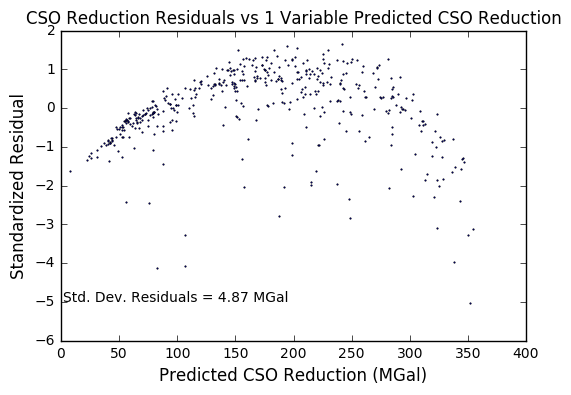

In [19]:
#Single Variable Regression for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

import numpy as np
import statsmodels.api as sm

def regress(yList,xList):   
    # y = list containing dependent variable values 
    # x = list of lists: each list contains values for all independent variables for each data point
    X = sm.add_constant(xList)
    results = sm.OLS(yList,X).fit()
    return results

upperGreenedAcreLimit = 1000.0  # Upper limit on greened acres for the regresions below 
limitedGreenedAcres = []
limitedCsoReduction = []

for run in range(0,numberOfRuns):
    if greenedAcres[run] <= upperGreenedAcreLimit:
        limitedGreenedAcres.append([greenedAcres[run]])
        limitedCsoReduction.append(csoReduction[run])
 
csoReductionVsTotalGreenedAcresStats = regress(limitedCsoReduction,limitedGreenedAcres)
#print "Exact r-squared:"
#print csoReductionVsTotalGreenedAcresStats.rsquared
print csoReductionVsTotalGreenedAcresStats.summary()
print csoReductionVsTotalGreenedAcresStats.params

# Generate Residuals Plot for LIMITED GA CSO reductions for each run vs total greened acres (combining LIDs) for each run
# LIMIT runs to those with GA less than an upper limit to avoid upper nonlinear range

X = sm.add_constant(limitedGreenedAcres)
yPredicted = np.dot(X,csoReductionVsTotalGreenedAcresStats.params)
residuals = limitedCsoReduction - yPredicted
stdDevResiduals = np.std(residuals, ddof=1) #ddof=1 for SAMPLE std. dev.
standardizedResiduals = [x / stdDevResiduals for x in residuals]

yPredictedMGal = [x/1e6 for x in yPredicted]
stdDevResidualsMGal = stdDevResiduals/1e6

(fig, ax1) = plt.subplots()
plt.title("CSO Reduction Residuals vs 1 Variable Predicted CSO Reduction")
ax1.plot(yPredictedMGal,standardizedResiduals,'ko',color = 'b',markersize = 1)
ax1.set_xlabel("Predicted CSO Reduction (MGal)",fontsize=12)
#ax1.set_ylabel("Residual (MGal)",fontsize=12)
ax1.set_ylabel("Standardized Residual",fontsize=12)
stdDevText = "Std. Dev. Residuals = %0.2f MGal" % stdDevResidualsMGal
ax1.text(2,-5,stdDevText)